In [ ]:
graphics_toolkit("gnuplot"); % use if "plot" does not work

## Solution of 1d diffusion + time 
### A) using 2d finite element method
Solve the following boundary value problem in 2d time-space domain using linear finite elements:

In [58]:
%% boundary value problem:
%   c*du/dt - (d^2)u/dx^2 = 0 inside of the domain (0,L)x(0,T)
%   u(0,t) = f0(t)
%   u(L,t) = fL(t)
%   u(x,0) = u0(x)

% parameters:
c = 5;
L = 14;
T = 100;
u0 = @(x)sin(x);

Consider rectangular domain $(0,L)\times(0,T)$ and its regular triangulation, i.e. prepare input matrices NODE, ELEM. Also AREAS and CENTERS (area and center of gravity for each triangle) may be useful.

In [59]:
%  triangulation of a rectangular domain (0,L)x(0,T)
nx=20; nt=40;
[coords1,coords2]=meshgrid(linspace(0,L,nx),linspace(0,T,nt)); % meshgrid
coords1=coords1(:); coords2=coords2(:);
NODE=[coords1 coords2];
n_NODE=size(NODE,1);
ELEM=rectangle_triangulation(nx,nt);
n_ELEM=size(ELEM,1);
AREAS=polyarea(coords1(ELEM),coords2(ELEM),2);
CENTERS=[mean(coords1(ELEM),2),mean(coords2(ELEM),2)];

Preparation of boundary conditions and material inputs:

In [60]:
%% boundary conditions inputs
DBOUNDARY=((coords1==0)|(coords1==L)|(coords2==0));
DVALUE=0*DBOUNDARY;
DVALUE(coords2==0)=u0(coords1(coords2==0));
DVALUE(coords1==L)=u0(L);
DVALUE = DVALUE(DBOUNDARY);
NBOUNDARY=[];  
NVALUE=0*ones(size(NBOUNDARY,1),1);
FREENODE=true(n_NODE,1); FREENODE(DBOUNDARY)=false;

%% other input data
MATERIALS1=c*ones(n_ELEM,1);
SOURCE=0*ones(n_ELEM,1); % source term

Construct FEM matrix and right hand side vector using local matrices and vectors:

In [61]:
%% construction of global matrix and rhs
AREAS=polyarea(coords1(ELEM),coords2(ELEM),2);
A=zeros(n_NODE);
b=zeros(n_NODE,1);
for i=1:n_ELEM

    % local matrix for the term "integral((d^2u/dx^2)*v) dx dt" (x1=x)
    x=NODE(ELEM(i,:),:);
    B_=[x(2,2)-x(3,2) x(3,2)-x(1,2) x(1,2)-x(2,2);
        x(3,1)-x(2,1) x(1,1)-x(3,1) x(2,1)-x(1,1)];
    J=abs(2*AREAS(i));
    DF=[x(2,1)-x(1,1) x(3,1)-x(1,1);
    x(2,2)-x(1,2) x(3,2)-x(1,2)];
    temp=[-1 1 0; -1 0 1]'*inv(DF);
    MXX_local=temp(:,1)*temp(:,1)'*AREAS(i);
    
    % local matrix for x2(=t) convection
    MT_local=MATERIALS1(i)*J*temp(:,2)*[1 1 1]/6;
    
    % add local matrices to the global matrix
    A(ELEM(i,:),ELEM(i,:))=A(ELEM(i,:),ELEM(i,:))+MXX_local+MT_local';
    
    % add local rhs to the global rhs
    b_local=SOURCE(i)*AREAS(i)/3;
    b(ELEM(i,:))=b(ELEM(i,:))+b_local;
end

Eliminate unknowns corresponding to Dirichlet nodes, modify the r. h. s. vector according to Neumann boundary conditions, and solve the resulting linear system:

In [62]:
%% modifications due to boundary conditions
u=zeros(n_NODE,1);
u(DBOUNDARY)=DVALUE;
b=b-A*u;
for i=1:length(NVALUE)
    x=NODE(NBOUNDARY(i,:),:);
    b(NBOUNDARY(i,:))=b(NBOUNDARY(i,:))+1/2*norm(x(2,:)-x(1,:))*NVALUE(i);
end

Plot solution:

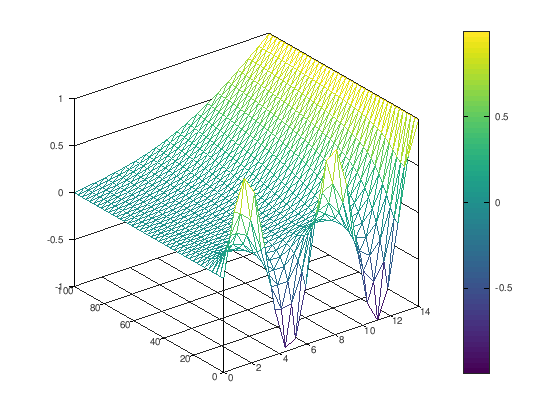

In [63]:
%% solution of the resulting linear system and visualization
u(FREENODE)=A(FREENODE,FREENODE)\b(FREENODE);
figure; 
trimesh(ELEM,coords1,coords2,u);
u_FEM2d_grid = reshape(u,nt,nx);
#imagesc([0,L],[0,T],u_FEM2d_grid);
set(gca,'YDir','normal')
colorbar()

## Numerical experiments:
1) Choose suitable model problem, find its analytic solution and compare. For example

$ c\cdot u_{t}'(x,t) - u_{xx}''(x,t) = 0 $

$ u(0,t)=u(1,t)=0 $

$ u(x,0)= \sin(\pi x) $

has the analytical solution $ u(x,t) = \sin( \pi x) \exp(-\frac{t}{c} \pi ^2 ) $

2) Compare with other numerical methods: 1d FEM + Euler, 1d FDM + Euler

### B) analytical (for specific model problem)

In [ ]:
x_grid = linspace(0,L,nx);
t_grid = linspace(0,T,nt);
[xx,tt]=meshgrid(x_grid,t_grid);
u_analyt=@(x,t)sin(pi*x).*exp(-t*pi^2/c);
u_analyt_grid = u_analyt(xx,tt);
figure; mesh(xx,tt,u_analyt_grid); title('analytical')
colorbar()

Plot the difference (absolute value):

In [ ]:
figure; mesh(xx,tt,abs(u_analyt_grid-u_FEM2d_grid)); title('FEM2d vs. analytical')
colorbar()

### C) using 1d finite element method + Euler time steps
(time discretization using Euler, domain discretization using FDM)

In [ ]:
delta_t=T/nt;  % length of one time step
t=linspace(0,T,nt+1); % time grid

%% solution using finite diferences - matrix preparation
h=1/(nx-1);            % length of one step
x=linspace(0,1,nx)';   % domain grid
A=-delta_t*diag(ones(nx-3,1),-1)+(c*h^2+2*delta_t)*diag(ones(nx-2,1))-delta_t*diag(ones(nx-3,1),1); % matrix assembly

%% Euler method (time steps)
u_old = u0(x);
u_FDM1d_grid = zeros(nt,nx);
u_FDM1d_grid(1,:)=u_old;
for i=2:nt
    b=h^2*c*u_old(2:end-1); % right hand side for FDM system
    u=A\b;                  % solution of the FDM linear system
    u_old = [0; u; 0];      % adding left and right point (with Dirichlet b. c.)
    u_FDM1d_grid(i,:)=u_old;
end
figure; mesh(xx,tt,u_FDM1d_grid); title('FDM1d+Euler')

Plot the difference (absolute value):

In [ ]:
figure; mesh(xx,tt,abs(u_analyt_grid-u_FDM1d_grid)); title('FEM1d+Euler vs. analytical')
colorbar()